#### Load required libraries

In [1]:
import os
import numpy as np
try:
    import pyviscous as vs 
except ImportError as e:
    import sys
    sys.path.append('../../')
    import pyviscous.pyviscous as vs

#### Load Sobol function
The Sobol function is defined as:
$$ y = \prod_{i=1}^{n} \frac{|4x_i-2|+a_i}{1+a_i} $$
Set $ n=10 $, then $ (x_1,…,x_{10}) $ are the ten input variables uniformly distributed in $[0,1]$.<br>
We can conveniently get all the three types of function by changing $ a_i$ ([Kucherenko et al., 2011](https://www.sciencedirect.com/science/article/abs/pii/S0951832010002437)).

| Type   | $a_i$                              |
|:---------|:--------------------------                   |
| Type A      | $ a_1 = a_2 = 0, a_3 = ... = a_n = 6.25 $ |
| Type B      | $ a_i = 6.25 $ |
| Type C      | $ a_i = 0 $ |

In [2]:
def Sobol_function(x, a):
    ''' Sobol function
    -------
    x: input array, shape (nSample,nVar).
    a: input array, shape (nSample,nVar).
    y: output array, shape (nSample,1).'''
    
    subPart = np.abs(4*x-2)
    y = np.prod((subPart+a)/(1+a), axis=1) 

    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Specify input and output configurations

In [3]:
rootPath  = '.'  # root path where demo data will be stored.
outputDir = os.path.join(rootPath,'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 10     # number of input x variables
paramLowerLimit = 0      # lower limit of x
paramUpperLimit = 1      # upper limit of x
nSample         = 10000  # number of input data samples

sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))
sampleCDFFile   = os.path.join(outputDir,'samplesCDF_nVar%d.txt'%(nVar))
sampleStdFile   = os.path.join(outputDir,'samplesStd_nVar%d.txt'%(nVar))

### Part 1. Generate & standradize data

#### Generate sample data

In [4]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input variable samples (x) 
x = np.zeros((nSample,nVar))
a = np.zeros((nSample,nVar)) # type C function
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding responses (y).
y = Sobol_function(x, a)

# Save sample data.
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Samples data: %s'%(sampleFile))


Samples data: ./outputs/samples_nVar10.txt


#### Standardize sample data 

In [5]:
# Read sample data (x,y).
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Standardize x.
print('Standardizing ...')
[nSample, nVar] = np.shape(x)
cdfx            = np.zeros_like(x)          # CDF of x.
zx              = np.zeros_like(x)         # standardized data zx.  
for iVar in range(nVar):
    cdfx[:,iVar], zx[:,iVar] = vs.standardize_data(x[:,iVar])         

# Standardize y.
cdfy, zy   = vs.standardize_data(y)

# Save CDF.
cdf_tmp    = np.concatenate((cdfx,cdfy), axis=1)    
header_str = ','.join(['X_CDF'+str(iVar+1) for iVar in range(nVar)])+',Y_CDF'
np.savetxt(sampleCDFFile,cdf_tmp,delimiter=',',header=header_str)
print('CDF data: %s'%(sampleFile))

# Save standardized data.
std_tmp    = np.concatenate((zx,zy), axis=1)    
header_str = ','.join(['X_STD'+str(iVar+1) for iVar in range(nVar)])+',Y_STD'
np.savetxt(sampleStdFile,std_tmp,delimiter=',',header=header_str)
print('Standardized data: %s'%(sampleFile))

Standardizing ...
CDF data: ./outputs/samples_nVar10.txt
Standardized data: ./outputs/samples_nVar10.txt


### Part 2. Calculate first-order sensitivity indices using VISCOUS 

In [6]:
# Load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'first'     # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]       # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                           # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                           # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.
    
N1, N2       = 1000, 1000  # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 'optimal'   # The number of components used in GMM inference. An integer or string "optimal". 
                           # If n_components is an integer, it will be used as the fixed user-provided number of components.
                           # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].

# Calculate sensitivity indeces using VISCOUS
sensIndex_first, fitted_gmm_ls_first = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  


Calculating first-order sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.013891



#### Look at sensitivity indices and Gaussian mixture model (GMM) results

In [7]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('S%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_first[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('S%s = %.4f'%(var_label, sensIndex_first[iGSA]))

S1 = 0.0139


In [8]:
# Look at best fitted GMM details of a specific variable group (eg, the 1st)
gmm = fitted_gmm_ls_first[0]
gmmWeights     = gmm.weights_            # shape (n_components,)
gmmMeans       = gmm.means_              # shape (n_components, n_variables). 
gmmCovariances = gmm.covariances_        # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components        # number of components
print('gmmNComponents = ',gmmNComponents)

gmmNComponents =  17


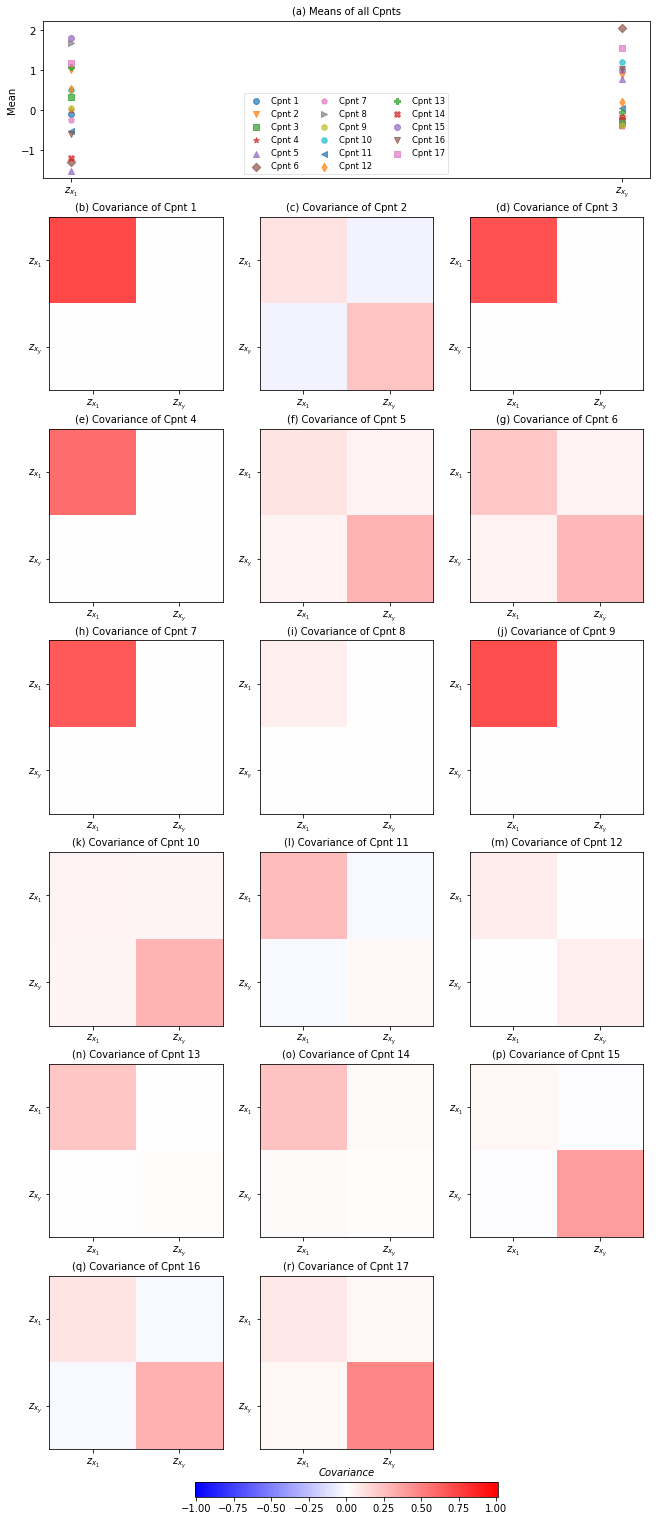

In [9]:
# Plot GMM used by a specific variable group (eg, the 1st)

var_name_ls = [r'${z_{x_{%d}}}$'%(i) for i in np.arange(1,nVar+1)]       # a list of all x variable names
var_name_ls.append(r'${z_{x_y}}$')                                       # append y variable name
ofile = os.path.join(outputDir,'gmm_mean_cov_x1_first.png')              # output figure file path

vs.plot_gmm_mean_cov(fitted_gmm_ls_first[0], var_name_ls, sensType, GSAIndex[0], ofile)

### Part 3. Calculate total-order sensitivity indices using VISCOUS 

In [10]:
# Load raw data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Load standardized data
data = np.loadtxt(sampleStdFile, skiprows=0, delimiter=',')
zx   = data[:,0:-1]
zy   = data[:,-1].reshape(-1,1)    

# Specify VISCOUS configurations
sensType     = 'total'      # two options for sensitivity index calculation: 'first' or 'total' 

GSAIndex     = [[0]]        # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                            # use vs.define_GSA_variable_index(nVar) if you want to compute each x variable' sensitivity indcies.
                            # use [[0],[1]] if you want to compute the sensitivity indices of x1 and x2.
        
N1, N2       = 1000, 1000   # Monte Carlo sample size. N1 is for outer loop, N2 is for inner loop.

n_components = 'optimal'    # The number of components used in GMM inference. An integer or string "optimal". 
                            # If n_components is an integer, it will be used as the fixed user-provided number of components.
                            # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].


# Calculate sensitivity indeces using VISCOUS
sensIndex_total, fitted_gmm_ls_total = vs.VISCOUS(x, y, zx, zy, sensType, GSAIndex, N1, N2, n_components)  

Calculating total-effect sensitivity indices...
--- variable group [0] --- 
--- fitting GMM...
--- calculating sensitivity index...
--- Sensitivity index = 0.980368



#### Look at sensitivity indices and Gaussian mixture model (GMM) results

In [11]:
# Look at sensitivity indices 
for iGSA in range(len(GSAIndex)):
    if len(GSAIndex[iGSA])==1:
        print('ST%d = %.4f'%(GSAIndex[iGSA][0]+1, sensIndex_total[iGSA]))
    else:
        var_label = ''
        for ind in GSAIndex[iGSA]:
            var_label = var_label+'%d,'%(ind+1)
        var_label = var_label.rstrip(',')
        print('ST%s = %.4f'%(var_label, sensIndex_total[iGSA]))

ST1 = 0.9804


In [12]:
# Look at the best fitted GMM details of a specific variable group (eg, the 1st)
gmm = fitted_gmm_ls_first[0]
gmmWeights     = gmm.weights_            # shape (n_components,)
gmmMeans       = gmm.means_              # shape (n_components, n_variables). 
gmmCovariances = gmm.covariances_        # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents = gmm.n_components        # number of components
print('gmmNComponents = ',gmmNComponents)

gmmNComponents =  17


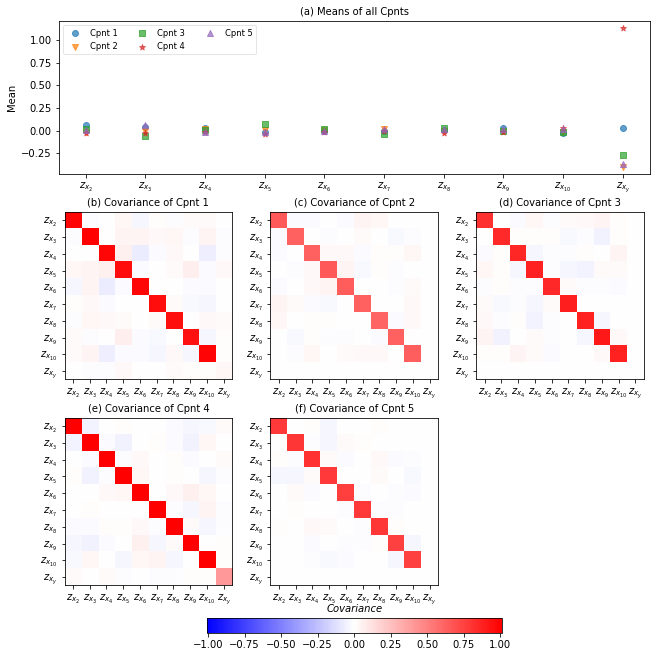

In [13]:
# Plot GMM used by a specific variable group (eg, the 1st)

var_name_ls = [r'${z_{x_{%d}}}$'%(i) for i in np.arange(1,nVar+1)]       # a list of all x variable names
var_name_ls.append(r'${z_{x_y}}$')                                       # append y variable name
ofile = os.path.join(outputDir,'gmm_mean_cov_x1_total.png')              # output figure file path

vs.plot_gmm_mean_cov(fitted_gmm_ls_total[0], var_name_ls, sensType, GSAIndex[0], ofile)